All the sentiment has been stored in IG_posts_with_sentiment.json and the overall score has been made as an equal average of taste, presentation, and creativity scores. Field: "overall_score"

Now, create Gephi bipartite graph (.csv files compatible as nodes and edges in Gephi)

In [7]:
# All necessary imports

import json
import itertools
import pandas as pd
import numpy as np

In [ ]:
# Gephi Creation

# First, the primary overview (one-mode projections of bipartite network)

with open('../outputs/IG_posts_with_sentiment.json', 'r', encoding='utf-8') as f:
    ig_posts = json.load(f)

# Initialize sets for nodes 
influencer_nodes = set()
restaurant_nodes = set()

# Dictionaries for edge mappings
# for influencers: map each restaurant to a set that reviewed it
restaurant_to_influencers = {}

# for restaurants: map each influencer to the set of restaurants they reviewed
influencer_to_restaurants = {}

# iterate and fill sets and mappings
for post in ig_posts:
    influencer = post.get("influencerUsername", "").strip()
    restaurant = post.get("restaurantName", "").strip()
    
    # skip if no influencer or restaurant
    if not influencer or not restaurant:
        continue
    
    # add to sets
    influencer_nodes.add(influencer)
    restaurant_nodes.add(restaurant)
    
    # add to mappings
    if restaurant not in restaurant_to_influencers:
        restaurant_to_influencers[restaurant] = set()
    restaurant_to_influencers[restaurant].add(influencer)
    
    if influencer not in influencer_to_restaurants:
        influencer_to_restaurants[influencer] = set()
    influencer_to_restaurants[influencer].add(restaurant)
    
# build edges influencer
# for every pair of influencers who reviewed the same restaurant, add an edge
influencer_edges = {}
for restaurant, influencers in restaurant_to_influencers.items():
    if len(influencers) > 1:
        for pair in itertools.combinations(sorted(influencers), 2):
            influencer_edges[pair] = influencer_edges.get(pair, 0) + 1

# build edges restaurant
# for every pair of restaurants reviewed by the same influencer, add an edge
restaurant_edges = {}
for influencer, restaurants in influencer_to_restaurants.items():
    if len(restaurants) > 1:
        for pair in itertools.combinations(sorted(restaurants), 2):
            restaurant_edges[pair] = restaurant_edges.get(pair, 0) + 1

# Create DataFrames for influencer nodes and edges:

df_influencer_nodes = pd.DataFrame({
    "Id": list(influencer_nodes),
    "Label": list(influencer_nodes),
})

# sort
df_influencer_nodes = df_influencer_nodes.sort_values("Id")

# convert influencer edges
influencer_edges_list = []
for (source, target), weight in influencer_edges.items():
    influencer_edges_list.append({"Source": source, "Target": target, "Weight": weight})

# create DataFrame
df_influencer_edges = pd.DataFrame(influencer_edges_list)

# Create DataFrames for restaurant nodes and edges.
df_restaurant_nodes = pd.DataFrame({
    "Id": list(restaurant_nodes),
    "Label": list(restaurant_nodes)
})
df_restaurant_nodes = df_restaurant_nodes.sort_values("Id")

restaurant_edges_list = []
for (source, target), weight in restaurant_edges.items():
    restaurant_edges_list.append({"Source": source, "Target": target, "Weight": weight})
df_restaurant_edges = pd.DataFrame(restaurant_edges_list)

# Save dataframes to the respective CSV files for Gephi
df_influencer_nodes.to_csv("../gephi/influencer_nodes.csv", index=False)
df_influencer_edges.to_csv("../gephi/influencer_edges.csv", index=False)
df_restaurant_nodes.to_csv("../gephi/restaurant_nodes.csv", index=False)
df_restaurant_edges.to_csv("../gephi/restaurant_edges.csv", index=False)

print("CSV files created:")
print(" - influencer_nodes.csv")
print(" - influencer_edges.csv")
print(" - restaurant_nodes.csv")
print(" - restaurant_edges.csv")



CSV files created:
 - influencer_nodes.csv
 - influencer_edges.csv
 - restaurant_nodes.csv
 - restaurant_edges.csv


In [18]:
# compare review count, rating, and overall score (Yelp vs Instagram sentiment)
# creating version 2 gephi files

# Load restaurants CSV
restaurants_df = pd.read_csv('../outputs/merged_restaurants_final.csv')
# Normalize restaurant names in CSV for matching (case insensitive)
restaurants_df['norm_name'] = restaurants_df['name'].astype(str).str.strip().str.lower()

# Load IG posts (with sentiments) JSON
with open('../outputs/IG_posts_with_sentiment.json', 'r', encoding='utf-8') as f:
    ig_posts = json.load(f)

# Filter IG posts: only include those with ratingAvailable: true.
# Normalize the restaurantName field.
valid_posts = [
    post for post in ig_posts 
    if post.get('ratingAvailable') is True and post.get('restaurantName', '').strip() != ''
]

# For all valid posts, create a normalized restaurant name.
for post in valid_posts:
    post['norm_restaurant'] = post.get('restaurantName', '').strip().lower()

print(f"Total IG posts: {len(ig_posts)}")
print(f"IG posts with ratingAvailable True: {len(valid_posts)}")


# Create a dictionary mapping normalized restaurant name -> list of IG posts mentioning it
posts_by_restaurant = {}
for post in valid_posts:
    norm_name = post['norm_restaurant']
    posts_by_restaurant.setdefault(norm_name, []).append(post)

# For each restaurant (normalized) compute:
# - IG_overall_score: average overall_score from IG posts
# - IG_review_count: number of IG posts for that restaurant
ig_agg = {}
for norm_name, posts in posts_by_restaurant.items():
    scores = [
        post.get("sentiment_analysis", {}).get("overall_score") 
        for post in posts if post.get("sentiment_analysis", {}).get("overall_score") is not None
    ]
    if scores:
        avg_score = sum(scores) / len(scores)
        ig_agg[norm_name] = {
            'IG_overall_score': round(avg_score, 2),
            'IG_review_count': len(scores)
        }
        
# combine restaurant data from CSV and IG
# Get the set of restaurants (by normalized name) from IG posts. These are the only ones we consider (around 500)
ig_restaurants = set(posts_by_restaurant.keys())

# Create a DataFrame for final restaurants.
final_restaurants = pd.DataFrame({'norm_name': list(ig_restaurants)})

# Merge the CSV info onto final_restaurants.
# Left join final_restaurants with restaurants_df on norm_name.
final_restaurants = final_restaurants.merge(
    restaurants_df[['norm_name', 'name', 'borough', 'rating', 'review_count']],
    on='norm_name',
    how='left'
)

# Merge the aggregated IG data onto final_restaurants.
final_restaurants = final_restaurants.merge(
    pd.DataFrame.from_dict(ig_agg, orient='index').reset_index().rename(columns={'index': 'norm_name'}),
    on='norm_name',
    how='left'
)

# For restaurants not present in CSV, fill missing CSV columns with NaN (or other defaults if you prefer).
final_restaurants['name'] = final_restaurants['name'].fillna(final_restaurants['norm_name'])
final_restaurants['borough'] = final_restaurants['borough'].fillna('Unknown')
final_restaurants['rating'] = final_restaurants['rating'].fillna(np.nan)
final_restaurants['review_count'] = final_restaurants['review_count'].fillna(0)

# Compute a difference metric: for restaurants that have both a CSV rating and an IG overall score.
# would be nice for analysis
final_restaurants['score_diff'] = final_restaurants.apply(
    lambda row: row['IG_overall_score'] - row['rating'] if pd.notnull(row['rating']) and pd.notnull(row['IG_overall_score']) else np.nan,
    axis=1
)

# Attempt to use the original CSV "name" if available;
# otherwise we use the normalized restaurant name.
final_restaurants['Label'] = final_restaurants['name']
# CONTINUE WITH UNIPARTITE APPROACH 

# Influencer Network
# Nodes: unique influencers from valid_posts.
influencer_set = set(post.get("influencerUsername", "").strip() for post in valid_posts)
influencer_nodes = pd.DataFrame({"Id": list(influencer_set), "Label": list(influencer_set)})

# Influencer edges: edge between two influencers if they reviewed the same restaurant.
influencer_edges = {}
for norm_rest, posts in posts_by_restaurant.items():
    influencers = sorted({ post.get("influencerUsername", "").strip() for post in posts })
    if len(influencers) > 1:
        for pair in itertools.combinations(influencers, 2):
            influencer_edges[pair] = influencer_edges.get(pair, 0) + 1

influencer_edges_df = pd.DataFrame([
    {"Source": pair[0], "Target": pair[1], "Weight": weight} 
    for pair, weight in influencer_edges.items()
])


# For restaurant edges:
# each influencer is mapped to the set of normalized restaurants they reviewed.
influencer_to_restaurants = {}
for post in valid_posts:
    influencer = post.get("influencerUsername", "").strip()
    norm_rest = post.get("norm_restaurant", "")
    if influencer and norm_rest:
        influencer_to_restaurants.setdefault(influencer, set()).add(norm_rest)

restaurant_edges = {}
for influencer, rest_set in influencer_to_restaurants.items():
    if len(rest_set) > 1:
        for pair in itertools.combinations(sorted(rest_set), 2):
            restaurant_edges[pair] = restaurant_edges.get(pair, 0) + 1

# use a lookup dictionary to create the restaraunt edges for Gephi
lookup = pd.Series(final_restaurants.Label.values, index=final_restaurants.norm_name).to_dict()
restaurant_edges_df = pd.DataFrame([
    {"Source": lookup.get(pair[0], pair[0]),
     "Target": lookup.get(pair[1], pair[1]),
     "Weight": weight}
    for pair, weight in restaurant_edges.items()
    if pair[0] in lookup and pair[1] in lookup
])

# output to csv files for use in gephi
influencer_nodes.to_csv("../gephi/influencer_nodes_2.csv", index=False)
influencer_edges_df.to_csv("../gephi/influencer_edges_2.csv", index=False)
final_restaurants[['norm_name', 'Label', 'borough', 'rating', 'review_count', 'IG_overall_score', 'IG_review_count', 'score_diff']]\
    .rename(columns={'norm_name': 'Id'})\
    .to_csv("../gephi/restaurant_nodes_2.csv", index=False)
restaurant_edges_df.to_csv("../gephi/restaurant_edges_2.csv", index=False)

print("CSV files generated:")
print(" - influencer_nodes_2.csv")
print(" - influencer_edges_2.csv")
print(" - restaurant_nodes_2.csv")
print(" - restaurant_edges_2.csv")


Total IG posts: 2753
IG posts with ratingAvailable True: 536
CSV files generated:
 - influencer_nodes_2.csv
 - influencer_edges_2.csv
 - restaurant_nodes_2.csv
 - restaurant_edges_2.csv


In [14]:
# Find the network statistics like nodes, edges, connected components, degree distribution, clustering, and path length
# For the purposes of the final presentation

import os
import glob
import json
import re
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import powerlaw

Influencer Network Analysis
Influencer Network: 82 nodes, 379 edges, 23 connected components
Degree distribution: mean = 9.24, std = 10.61
Degree quantiles (min, 25th, median, 75th, max): [ 0.    0.25  3.   20.75 33.  ]
Power law fit: alpha = 11.18, xmin = 26.0
Average clustering coefficient: 0.419
Average shortest path length (largest component): 2.107


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\derek\\OneDrive\\Documents\\cloutbites\\degree\\degree_distribution\\Influencer Network.png'

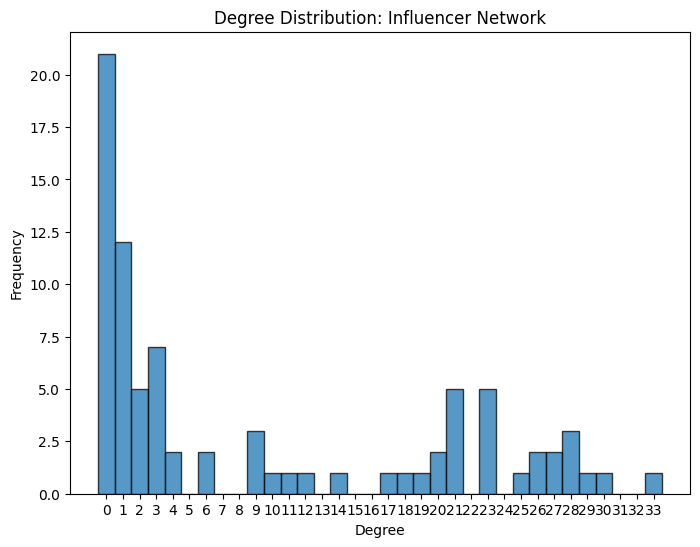

In [ ]:
# begin analysis

def analyze_network(nodes_file, edges_file, network_name="Network"):
    print(f"{network_name} Analysis") # influencer vs restaurant since this is treated as bipartite
    # Load nodes and edges.
    nodes_df = pd.read_csv(nodes_file)
    edges_df = pd.read_csv(edges_file)
    
    # Create an undirected graph.
    G = nx.Graph()
    for _, row in nodes_df.iterrows():
        node_id = row["Id"]
        label = row.get("Label", node_id)
        G.add_node(node_id, label=label)
    
    for _, row in edges_df.iterrows():
        source = row["Source"]
        target = row["Target"]
        weight = row.get("Weight", 1)
        G.add_edge(source, target, weight=weight)
    
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    n_components = nx.number_connected_components(G)
    print(f"{network_name}: {n_nodes} nodes, {n_edges} edges, {n_components} connected components")
    
    # Degree distribution.
    degrees = np.array([d for n, d in G.degree()])
    mean_deg = degrees.mean()
    std_deg = degrees.std()
    print(f"Degree distribution: mean = {mean_deg:.2f}, std = {std_deg:.2f}")
    quantiles = np.percentile(degrees, [0, 25, 50, 75, 100])
    print("Degree quantiles (min, 25th, median, 75th, max):", quantiles)
    
    if len(degrees) > 0:
        fit = powerlaw.Fit(degrees, discrete=True, verbose=False)
        alpha = fit.power_law.alpha
        xmin = fit.power_law.xmin
        print(f"Power law fit: alpha = {alpha:.2f}, xmin = {xmin}")
    else:
        print("Skipping power law fit.")
    
    # Clustering coefficient.
    avg_clustering = nx.average_clustering(G)
    print(f"Average clustering coefficient: {avg_clustering:.3f}")
    
    # Average shortest path length in largest connected component.
    if n_components > 0:
        largest_cc = max(nx.connected_components(G), key=len)
        G_lcc = G.subgraph(largest_cc)
        avg_path_length = nx.average_shortest_path_length(G_lcc)
        print(f"Average shortest path length (largest component): {avg_path_length:.3f}")
    
    # Plot degree distribution histogram.
    plt.figure(figsize=(8, 6))
    # Use bins from min to max degree + 1 for clarity.
    bins = np.arange(degrees.min(), degrees.max() + 2) - 0.5
    plt.hist(degrees, bins=bins, edgecolor='black', alpha=0.75)
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title(f"Degree Distribution: {network_name}")
    plt.xticks(range(int(degrees.min()), int(degrees.max())+1))
    plt.savefig(f"../degree/degree_distribution/{nodes_file}.png", bbox_inches='tight')
    plt.close()
    print(f"Saved degree distribution plot")

    
# Process influencer network files.
analyze_network("../gephi/influencer_nodes.csv", "../gephi/influencer_edges.csv", network_name="Influencer Network")

for node_file in sorted(glob.glob("../gephi/influencer_nodes_*.csv")):
    base = node_file.split("influencer_nodes_")[1].split(".csv")[0]
    edge_file = f"../gephi/influencer_edges_{base}.csv"
    analyze_network(node_file, edge_file, network_name=f"Influencer Network {base}")

# Process restaurant network files.
analyze_network("../gephi/restaurant_nodes.csv", "../gephi/restaurant_edges.csv", network_name="Restaurant Network")

for node_file in sorted(glob.glob("../gephi/restaurant_nodes_*.csv")):
    base = node_file.split("restaurant_nodes_")[1].split(".csv")[0]
    edge_file = f"../gephi/restaurant_edges_{base}.csv"
    analyze_network(node_file, edge_file, network_name=f"Restaurant Network {base}")

# check outlier restaurants (additional calculation)
print("Restaurant Ratings Analysis")

merged_restaurants = pd.read_csv("../gephi/merged_restaurants_final.csv")
# Assume the rating column is named "rating" and is numeric.
ratings = merged_restaurants["rating"].dropna().astype(float)
avg_rating = ratings.mean()
std_rating = ratings.std()
threshold_hi = avg_rating + 2 * std_rating
threshold_lo = avg_rating - 2 * std_rating
count_hi = (ratings > threshold_hi).sum()
count_lo = (ratings < threshold_lo).sum()

print(f"Average restaurant rating: {avg_rating:.2f} (std: {std_rating:.2f})")
print(f"Unreasonably high ratings (> {threshold_hi:.2f}): {count_hi}")
print(f"Unreasonably low ratings (< {threshold_lo:.2f}): {count_lo}")

print("\n Overall Score Analysis")

with open("../outputs/IG_posts_with_sentiment.json", "r", encoding="utf-8") as f:
    ig_posts = json.load(f)
overall_scores = []
for post in ig_posts:
    sentiment = post.get("sentiment_analysis", {})
    overall = sentiment.get("overall_score")
    if overall is not None:
        try:
            overall_scores.append(float(overall))
        except Exception:
            pass
overall_scores = np.array(overall_scores)
avg_overall = overall_scores.mean()
std_overall = overall_scores.std()
threshold_hi_overall = avg_overall + 2 * std_overall
threshold_lo_overall = avg_overall - 2 * std_overall
count_hi_overall = (overall_scores > threshold_hi_overall).sum()
count_lo_overall = (overall_scores < threshold_lo_overall).sum()

print(f"Average overall score: {avg_overall:.2f} (std: {std_overall:.2f})")
print(f"Unreasonably high overall scores (> {threshold_hi_overall:.2f}): {count_hi_overall}")
print(f"Unreasonably low overall scores (< {threshold_lo_overall:.2f}): {count_lo_overall}")
